In [8]:
import numpy as np 
import math 
from sklearn.metrics import mean_squared_error

### 数据准备部分

In [9]:
def shuffle_data(X,y,seed=None):
    "将X和y的数据进行随机排序/乱序化"
    if seed:
        np.random.seed(seed)
    idx=np.arange(X.shape[0])
    print(type(idx))
    np.random.shuffle(idx)
    return X[idx],y[idx] #对于np.array，idx作为index数组可以改变array的顺序

def train_test_split(X,y,test_size=0.5,shuffle=True,seed=None):
    '将数据集根据test_size分成训练集和测试集，可以指定是否随机洗牌'
    if shuffle:
        X,y=shuffle_data(X,y,seed)
    split_i=len(y)-int(len(y)//(1/test_size))
    #split_i=len(y)-int(len(y)*test_size)
    X_train,X_test=X[:split_i],X[split_i:]
    y_train,y_test=y[:split_i],y[split_i:]
    
    return X_train,X_test,y_train,y_test

from sklearn.datasets import make_regression
import matplotlib.pylab as plt

X,y=make_regression(n_samples=100,n_features=1,noise=20)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

<class 'numpy.ndarray'>


因为使用make_regression函数使得X乱序，在绘制matplot的图像时会有问题，所以对于X进行排序

In [10]:
s=sorted([(X_test[i][0],y_test[i]) for i in range(len(X_test))],key=lambda j:j[0])

X_test=np.array([[j[0]] for j in s])
y_test=np.array([j[1] for j in s])

## 线性回归

In [11]:
class Regression(object):
    
    """
        基础线性回归模型，使用输入的X和y进行参数回归
        超参：
        n_iterations:int 训练的步数
        learning_rate:float 学习率
        内部函数:
        initialize_weights:初始化参数
        fit:开始训练
        predict:预测
        内部的数据:
        n_iterations
        learning_rate
        regularization:正则化参数
        regularization.grad:正则化的梯度函数
    """
    
    def __init__(self,n_iterations,learning_rate):
        self.n_iterations=n_iterations
        self.learning_rate=learning_rate
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
    
    def initialize_weights(self,n_features):
        """初始化系数，输入是feature的个数，输出是一个随机初始化好的参数矩阵,[-1/sqrt(N),1/sqrt(N)]"""
        limit=1/math.sqrt(n_features)
        self.w=np.random.uniform(-limit,limit,(n_features,))
        # Uniform Distribution/Xavier/MSRA
        
        
    def fit(self,X,y):
        #插入偏置列1到X中
        X=np.insert(X,0,1,axis=1)#给每一行的第0列增加一个1
        self.training_errors=[]#保存每一次步长的训练Loss
        self.initialize_weights(n_features=X.shape[1])#初始化参数w
        
        #进行梯度下降迭代
        for i in range(self.n_iterations):
            y_pred=X.dot(self.w)#进行预测
            #计算Loss
            mse=np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_errors.append(mse)#将Loss加入到training_errors的数组中
            #计算带有正则化项的梯度
            g_w=-(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            #根据梯度下降的算法更新参数
            self.w-=self.learning_rate*g_w
            
    def predict(self,X):
        #通过输入X预测一个样本
        X=np.insert(X,0,1,axis=1)
        pred=X.dot(self.w)
        return pred
    

array([ 3.04901402, 66.95531265])

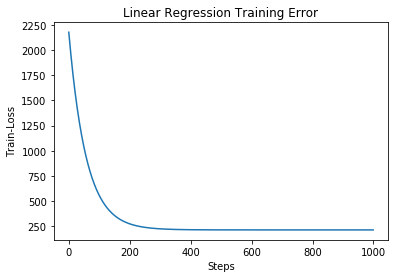

In [12]:
model=Regression(n_iterations=1000,learning_rate=0.01)

model.fit(X_train,y_train)

training,=plt.plot(range(len(model.training_errors)),model.training_errors,label="Training Error")
plt.title("Linear Regression Training Error")
plt.ylabel("Train-Loss")
plt.xlabel("Steps")

model.w

### 评价模型

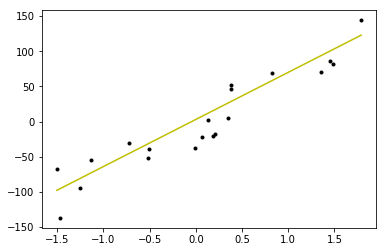

In [13]:
y_pred=model.predict(X_test)

mse=mean_squared_error(y_pred,y_test)

mse

plt.plot(X_test,y_test,'k.')
plt.plot(X_test,y_pred,'Y')

### 带有最小二乘法的线性回归

In [53]:
def lsm_function(X,y):
    G=np.mat(np.insert(X,0,1,axis=1))
    return np.squeeze(np.asarray((G.T.dot(G)).I.dot(G.T).dot(y)))

In [54]:
lsm_function(X_train,y_train)

array([ 1.76645796, 28.96240671])

In [55]:
class LinearRegression(Regression):
    """带有最小二乘法的线性回归
    参数:
    -------------
    n_iterations
    
    learning_rate
    
    gradient_descent:bool 
        决定是否使用梯度下降法，如果是True则使用梯度下降，False使用最小二乘
    """
    def __init__(self,n_iterations=500,learning_rate=0.1,gradient_descent=True):
        self.gradient_descent=gradient_descent
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
        super(LinearRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
    
    def fit(self,X,y):
        if not self.gradient_descent:
            self.w=lsm_function(X,y)
        else:
            super(LinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(LinearRegression,self).predict(X)
        

In [56]:
model=LinearRegression(n_iterations=1000,learning_rate=0.1,gradient_descent=False)

In [57]:
model.fit(X_train,y_train)

In [58]:
model.w

array([ 1.76645796, 28.96240671])

In [59]:
def test_and_draw(model):
    y_pred=model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

方差: 269.13175647924027


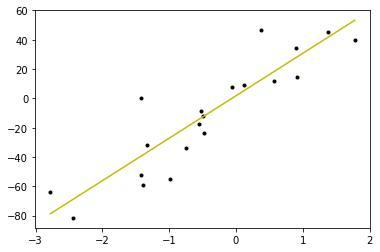

In [60]:
test_and_draw(model)

## 正则化回归

In [4]:
class l1_regularization():
    """L1正则化类/函数
    参数:
    
    alpha--L1正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    def __call__(self,w):
        return self.alpha*np.linalg.norm(w,ord=1)
    def grad(self,w):
        #w>0->w`=1;w<0->w`=0;w==0->w`=0
        return self.alpha*np.sign(w)

In [72]:
l1=l1_regularization(alpha=0.01)

In [73]:
l1([-3,4])

0.07

In [75]:
l1.grad([-3,4,0])

array([-0.01,  0.01,  0.  ])

### L2正则化参数

In [5]:
class l2_regularization():
    """L2正则化参数
    参数：
    
    alpha 正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    
    def __call__(self,w):
        return self.alpha*0.5*w.T.dot(w)
    
    def grad(self,w):
        return self.alpha*w

class LassoLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l1_regularization(alpha=alpha)
        super(LassoLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(LassoLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(LassoLinearRegression,self).predict(X)

model=LassoLinearRegression(alpha=120,n_iterations=1000,learning_rate=0.1)

model.fit(X_train,y_train)

model.w

test_and_draw(model)

NameError: name 'X_train' is not defined